# Linear prediction (very naive implementation)

Linear prediction has a long history  (see Makhoul, J. Linear prediction: A tutorial review. Proc. IEEE 63, 561–580 (1975)).

This tutorial only covers the very basics, in a very sloppy manner:
1. auto-correlation
2. Levison-Durvison recursion
3. reflection coefficients

Functions are implemented based on Numpy. 

In [4]:
import os
import sys
import numpy as np
import scipy.io.wavfile

import tool_lib
import plot_lib
import IPython.display

In [3]:
import torch
import torch.nn as torch_nn
import torch.nn.functional as torch_nn_func
import sys

# wrapper functions for plotting
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams.update({'font.size': 12})

def plot_data(x_data, y_data, fig, axis, xlabel, ylabel, title):
    axis.plot(x_data, y_data, 'k')
    axis.grid(True)
    axis.set_xlabel(xlabel)
    axis.set_ylabel(ylabel)
    axis.set_title(title)
    return fig, axis

A severly simplified flowchart to conduct LPC analysis and synthesis:
```c

Input waveform 
   |
   | (pre-emphasis)
   | framing and windowing 
   V
Framed waveforms
for each frame: 
        |
        | auto-correlation
        V
  Auto-corr coefficients
        |
        | LP analysis (Levison-Durbin recursion)
        V
   LPC coefficients
   Reflection coefficients
   Residual / excitation waveform  
        |
        | LP synthesis
        v
Framed signals
     |
     | overlap-add
     v
Reconstructed waveform
```


## LP API definition

Here is the definition of the LPC API.

It is also available in `core_scripts/data_io/dsp_tools.py`. (This API is used in before data is converted into torch.tensors, see [this note](#finalnote) at the bottom of this notebook)

We here assumes the LPC model (z-domain) to be

$\begin{align}
H(z) &= \frac{1}{1 - bz^{-1}} \frac{G}{a_0 + \sum_{i=1}^{M}a_i z^{-i}} \\
     &= \frac{1}{1 - bz^{-1}} \frac{G}{a_0 + a_1 z^{-1} + \cdots + a_{M} z^{M}} 
\end{align}$

where $a_0=1$,  $G$ is the gain,  and $b$ is the optional coefficient for pre-emphasis filter.

In the code, we call $M$ as the order of the model. An $M$-order LPC model has $M$ poles.

We will explain each method in this API one by one.

In [10]:
class LPClite(object):
    """ A lite LPC analyzer & synthesizr
    Note that this is based on numpy, not Pytorch
    It can be used for pre-processing when loading data, or use
    it as data transformation function
    (see message at top)
    
    Example:
        # load waveform
        sr, wav = wav_tools.waveReadAsFloat(wav_path)
        m_lpc = LPClite(320, 80)
        # LPC analysis 
        lpc_coef, _, rc, gain, err, err_overlapped = m_lpc.analysis(wav)
        # LPC synthesis
        wav_re = m_lpc.synthesis(lpc_coef, err, gain)
        # rc to LPC 
        lpc_coef_tmp = m_lpc._rc2lpc(lpc_coef)
        np.std(lpc_coef_tmp - lpc_coef)
    """
    def __init__(self, fl=320, fs=80, order=29, window='blackman', 
                 flag_emph=True, emph_coef=0.97):
        """LPClite(fl=320, fs=80, order=30, window='blackman')
        Args
        ----
          fl: int, frame length
          fs: int, frame shift
          order: int, order of LPC, [1, a_1, a_2, ..., a_order]
          window: str, 'blackman' or 'hanning'
          flag_emph: bool, whether use pre-emphasis (default True)
          emph_coef: float, coefficit for pre-emphasis filter (default 0.97)

        Note that LPC model is defined as:
           1                          Gain 
        -------- --------------------------------------------- 
        1- bz^-1 a_0 + a_1 z^-1 + ... + a_order z^-(order)
        
        b = emph_coef if flag_emph is True
        b = 0 otherwise
        """
        self.fl = fl
        self.fs = fs
        # 
        self.order = order
        self.flag_emph = flag_emph
        self.emph_coef = emph_coef

        if np.abs(emph_coef) >= 1.0:
            print("Warning: emphasis coef {:f} set to 0.97".format(emph_coef))
            self.emph_coef = 0.97

        if window == 'hanning':
            self.win = np.hanning(self.fl)
        else:
            self.win = np.blackman(self.fl)
            
        return
    
    def analysis(self, wav):
        """lpc_coef, ld_err, gamma, gain, framed_err, err_signal = analysis(wav)
        
        LPC analysis on each frame
        
        input
        -----
          wav: np.array, (length, 1)
          
        output
        ------
          lpc_coef:   np.array, LPC coeff, (frame_num, lpc_order + 1)
          ld_err:     np.array, LD analysis error, (frame_num, lpc_order + 1)
          gamma:      np.array, reflection coefficients, (frame_num,lpc_order)
          gain:       np.array, gain, (frame_num, 1)
          framed_err: np.array, LPC error per frame, (frame_num, frame_length)
          eer_signal: np.array, overlap-added excitation (length, 1)

        Note that framed_err is the excitation signal from LPC analysis on each
        frame. eer_signal is the overlap-added excitation signal.
        """
        if self.flag_emph:
            wav_tmp = self._preemphasis(wav)
        else:
            wav_tmp = wav

        # framing & windowing
        frame_wined = self._windowing(self._framing(wav_tmp[:, 0]))

        # auto-correlation
        auto = self._auto_correlation(frame_wined)

        # LD analysis
        lpc_coef, lpc_err, gamma_array, gain = self._levison_durbin(auto)

        # get LPC excitation signals in each frame
        framed_err = self._lpc_analysis_core(lpc_coef, frame_wined, gain)

        # overlap-add for excitation signal
        err_signal = self._overlapadd(framed_err)
        
        return lpc_coef, lpc_err, gamma_array, gain, framed_err, err_signal
    
    def synthesis(self, lpc_coef, framed_err, gain):
        """wav = synthesis(lpc_coef, framed_err, gain):
        
        LPC synthesis (and overlap-add)
        
        input
        -----
          lpc_coef:   np.array, LPC coeff, (frame_num, lpc_order + 1)
          framed_err: np.array, LPC excitations, (frame_num, frame_length)
          gain:       np.array, LPC gain, (frame_num, 1)
        
        output
        ------
          wav: np.array, (length, 1)
        
        This function does LPC synthesis in each frame and create
        the output waveform by overlap-adding
        """
        framed_x = self._lpc_synthesis_core(lpc_coef, framed_err, gain)
        wav_tmp = self._overlapadd(framed_x)
        if self.flag_emph:
            wav_tmp = self._deemphasis(wav_tmp)
        return wav_tmp

    def _preemphasis(self, wav):
        """ wav_out = _preemphasis(wav)

        input
        -----
          wav: np.array, (length)

        output
        ------
          wav: np.array, (length)
        """
        wav_out = np.zeros_like(wav) + wav
        wav_out[1:] = wav_out[1:] - wav_out[0:-1] * self.emph_coef
        return wav_out

    def _deemphasis(self, wav):
        """ wav_out = _deemphasis(wav)

        input
        -----
          wav: np.array, (length)

        output
        ------
          wav: np.array, (length)
        """
        wav_out = np.zeros_like(wav) + wav
        for idx in range(1, wav.shape[0]):
            wav_out[idx] = wav_out[idx] + wav_out[idx-1] * self.emph_coef
        return wav_out

    def _framing(self, wav):
        """F = _framed(wav)
        
        Framing the signal
        
        input
        -----
          wav: np.array, (length)

        output
        ------
          F: np.array, (frame_num, frame_length)
        """
        frame_num = (wav.shape[0] - self.fl) // self.fs + 1
        F = np.zeros([frame_num, self.fl], dtype=wav.dtype)
        for frame_idx in np.arange(frame_num):
            F[frame_idx, :] = wav[frame_idx*self.fs : frame_idx*self.fs+self.fl]
        return F
    
    def _windowing(self, framed_x):
        """windowing
        """
        return framed_x * self.win
    
    
    def _overlapadd(self, framed_x):
        """wav = _overlapadd(framed_x)
        
        Do overlap-add on framed (and windowed) signal
        
        input
        -----
          framed_x: np.array, (frame_num, frame_length)
          
        output
        ------
          wav: np.array, (length, 1)
        
        length = (frame_num - 1) * frame_shift + frame_length
        """
        # waveform length
        wavlen = (framed_x.shape[0] - 1) * self.fs + self.fl
        wavbuf = np.zeros([wavlen])
        
        # buf to save overlapped windows (to normalize the signal amplitude)
        protobuf = np.zeros([wavlen])
        win_prototype = self._windowing(self._framing(np.ones_like(protobuf)))
        
        # overlap and add
        for idx in range(framed_x.shape[0]):
            frame_s = idx * self.fs
            wavbuf[frame_s : frame_s + self.fl] += framed_x[idx]
            protobuf[frame_s : frame_s + self.fl] += win_prototype[idx]
        
        # remove the impact of overlapped windows
        #protobuf[protobuf<1e-05] = 1.0
        wavbuf = wavbuf / protobuf.mean()
        return np.expand_dims(wavbuf, axis=1)
    
    def _lpc_analysis_core(self, lpc_coef, framed_x, gain):
        """framed_err = _lpc_analysis_core(lpc_coef, framed_x, gain)
        
        LPC analysis on frame
        MA filtering: e[n] = \sum_k=0 a_k x[n-k] / gain
        
        input
        -----
          lpc_coef: np.array, (frame_num, order + 1)
          framed_x: np.array, (frame_num, frame_length)
          gain: np.array,     (frame_num, 1)
          
        output
        ------
          framed_err: np.array, (frame_num, frame_length)
        
        Note that lpc_coef[n, :] = (1, a_1, a_2, ..., a_order) for n-th frame
        framed_x[n, :] = (x[0], x[1], ..., x[frame_len]) for n-th frame
        """
        # 
        frame_num = framed_x.shape[0]
        frame_len = framed_x.shape[1]
        
        # lpc order (without the a_0 term)
        order = lpc_coef.shape[1] - 1
        
        # pad zero, every frame has [0, ..., 0, x[0], x[1], ..., x[frame_len]]
        tmp_framed = np.concatenate(
            [np.zeros([frame_num, order + 1]), framed_x], axis=1)
        
        # flip to (x[frame_len], ... x[1], x[0], 0, ..., 0)
        tmp_framed = tmp_framed[:, ::-1]

        # LPC excitation buffer
        framed_err = np.zeros_like(framed_x)
        
        # e[n] = \sum_k=0 a[k] x[n-k] 
        # do this for all frames and n simultaneously
        for k in range(self.order + 1):
            # a[k]
            tmp_coef = lpc_coef[:, k:k+1]
            
            # For each frame
            # RHS = [x[n-k], x[n-k-1], ..., ] * a[k]
            # 
            # By doing this for k in [0, order]
            # LHS = [e[n],   e[n-1],   ...]
            #       [x[n-0], x[n-0-1], ..., ] * a[0]
            #     + [x[n-1], x[n-1-1], ..., ] * a[1]
            #     + [x[n-2], x[n-2-1], ..., ] * a[2]
            #     + ...
            # We get the excitation for one frame
            # This process is conducted for all frames at the same time
            framed_err += tmp_framed[:, 0:frame_len] * tmp_coef
            
            # roll to [x[n-k-1], x[n-k-2], ..., ]
            tmp_framed = np.roll(tmp_framed, -1, axis=1)

        # revese to (e[0], e[1], ..., e[frame_len])
        return framed_err[:, ::-1] / gain
    
    def _lpc_synthesis_core(self, lpc_coef, framed_err, gain):
        """framed_x = _lpc_synthesis_core(lpc_coef, framed_err, gain)
        
        AR filtering: x[n] = gain * e[n] - \sum_k=0 a_k x[n-k]
        LPC synthesis on frame
        
        input
        -----
          lpc_coef:   np.array, (frame_num, order + 1)
          framed_err: np.array, (frame_num, frame_length)
          gain:       np.array, (frame_num, 1)
          
        output
        ------
          framed_x:   np.array, (frame_num, frame_length)
        
        Note that 
        lpc_coef[n, :] = (1, a_1, a_2, ..., a_order),  for n-th frame
        framed_x[n, :] = (x[0], x[1], ..., x[frame_len]), for n-th frame
        """
        frame_num = framed_err.shape[0]
        frame_len = framed_err.shape[1]
        order = lpc_coef.shape[1] - 1
        
        # pad zero 
        # the buffer looks like 
        #  [[0, 0, 0, 0, 0, ... x[0], x[1], x[frame_length -1]],  -> 1st frame
        #   [0, 0, 0, 0, 0, ... x[0], x[1], x[frame_length -1]],  -> 2nd frame
        #   ...] 
        framed_x = np.concatenate(
            [np.zeros([frame_num, order]), np.zeros_like(framed_err)], axis=1)
        
        # flip the cofficients of each frame as [a_order, ..., a_1, 1]
        lpc_coef_tmp = lpc_coef[:, ::-1]
        
        # synthesis (all frames are down at the same time)
        for idx in range(frame_len):
            # idx+order so that it points to the shifted time idx
            #                                    idx+order
            # [0, 0, 0, 0, 0, ... x[0], x[1], ... x[idx], ]
            # gain * e[n]
            framed_x[:, idx+order] = framed_err[:, idx] * gain[:, 0]
            
            # [x[idx-1-order], ..., x[idx-1]] * [a_order, a_1]
            pred = np.sum(framed_x[:, idx:idx+order] * lpc_coef_tmp[:, :-1], 
                          axis=1)
            
            # gain * e[n] - [x[idx-1-order], ..., x[idx-1]] * [a_order, a_1]
            framed_x[:, idx+order] = framed_x[:, idx+order] - pred
            
        # [0, 0, 0, 0, 0, ... x[0], x[1], ... ] -> [x[0], x[1], ...]
        return framed_x[:, order:] 
    
    def _auto_correlation(self, framed_x):
        """ autocorr = _auto_correlation(framed_x)

        input
        -----
          framed_x: np.array, (frame_num, frame_length), frame windowed signal
        
        output
        ------
          autocorr: np.array, auto-correlation coeff (frame_num, lpc_order+1)
        """
        # (frame_num, order)
        autocor = np.zeros([framed_x.shape[0], self.order+1])
        
        # loop and compute auto-corr (for all frames simultaneously)
        for i in np.arange(self.order+1):
            autocor[:, i] = np.sum(
                framed_x[:, 0:self.fl-i] * framed_x[:, i:],
                axis=1)
            #print(autocor[0, i])
            #autocor[:, i] = 0
            #for idx in np.arange(self.fl):
            #    if (idx + i) < self.fl:
            #        autocor[:, i] += framed_x[:, idx] * framed_x[:, idx + i]
            #    else:
            #        break
            #print(autocor[0, i])
        # (frame_num, order)
        return autocor
    
    def _levison_durbin(self, autocor):
        """lpc_coef_ou, lpc_err, gamma_array, gain = _levison_durbin(autocor)
        Levison durbin 
        
        input
        -----
          autocor: np.array, auto-correlation, (frame_num, lpc_order+1)
        
        output
        ------
          lpc_coef: np.array, LPC coefficients, (frame_num, lpc_order+1)
          lpc_err: np.array, LPC error, (frame_num, lpc_order+1)
          gamma: np.array, reflection coeff, (frame_num, lpc_order)
          gain: np.array, gain, (frame_num, 1)
          
        Note that lpc_coef[n] = (1, a_2, ... a_order) for n-th frame
        """
        # (frame_num, order)
        frame_num, order = autocor.shape 
        order = order - 1
        polyOrder = order + 1
        
        # to log down the invalid frames
        tmp_order = np.zeros([frame_num], dtype=np.int32) + polyOrder

        lpc_coef = np.zeros([frame_num, 2, polyOrder])
        lpc_err = np.zeros([frame_num, polyOrder])
        gamma_array = np.zeros([frame_num, order])
        gain = np.zeros([frame_num])
        
        lpc_err[:, 0] = autocor[:, 0]
        lpc_coef[:, 0, 0] = 1.0

        for index in np.arange(1, polyOrder):
            
            lpc_coef[:, 1, index] = 1.0
            
            # compute gamma
            #   step1.
            gamma = np.sum(lpc_coef[:, 0, 0:(index)] * autocor[:, 1:(index+1)], 
                           axis=1)
            #   step2. check validity of lpc_err
            ill_idx = lpc_err[:,index-1] < 1e-07
            #      also frames that should have been stopped in previous iter
            ill_idx = np.bitwise_or(ill_idx, tmp_order < polyOrder)
            #   step3. make invalid frame gamma=0
            gamma[ill_idx] = 0
            gamma[~ill_idx] = gamma[~ill_idx] / lpc_err[~ill_idx,index-1]
            gamma_array[:, index-1] = gamma
            #   step4. log down the ill frames
            tmp_order[ill_idx] = index

            lpc_coef[:, 1, 0] = -1.0 * gamma
            if index > 1:
                lpc_coef[:, 1, 1:index] = lpc_coef[:, 0, 0:index-1] \
                + lpc_coef[:, 1, 0:1] * lpc_coef[:, 0, 0:index-1][:, ::-1]

            lpc_err[:, index] = lpc_err[:, index-1] * (1 - gamma * gamma)
            lpc_coef[:, 0, :] = lpc_coef[:, 1, :]
        
        # flip to (1, a_1, ..., a_order)
        lpc_coef = lpc_coef[:, 0, ::-1]
        
        # output LPC coefficients
        lpc_coef_ou = np.zeros([frame_num, polyOrder])
        
        # if high-order LPC analysis is not working
        # each frame may require a different truncation length
        for idx in range(frame_num):
            lpc_coef_ou[idx, 0:tmp_order[idx]] = lpc_coef[idx, 0:tmp_order[idx]]
            
        # get the gain, when tmp_order = polyOrder, tmp_order-2 -> order-1, 
        #  last element of the lpc_err buffer
        gain = np.sqrt(lpc_err[np.arange(len(tmp_order)), tmp_order-2])
        
        # if the gain is zero, it means analysis error is zero, 
        gain[gain < 1e-07] = 1.0

        # (frame_num, order)
        return lpc_coef_ou, lpc_err, gamma_array, np.expand_dims(gain, axis=1)
    
    def _rc2lpc(self, rc):
        """lpc_coef = _rc2lpc(rc)
        from reflection coefficients to LPC coefficients
        forward Levinson recursion
        
        input
        -----
          rc: np.array, (frame_num, lpc_order)
        
        output
        ------
          lpc_coef, np.array, (frame_num, lpc_order+1)

        Note that LPC model is defined as:
                            Gain 
        ---------------------------------------------
        a_0 + a_1 z^-1 + ... + a_order z^-(order)

        Thus, the reflection coefficitns [gamma_1, ... gamma_order]
        """
        # (frame_num, order)
        frame_num, order = rc.shape 
        polyOrder = order + 1
        
        lpc_coef = np.zeros([frame_num, 2, polyOrder])
        lpc_coef[:, 0, 0] = 1.0        
        for index in np.arange(1, polyOrder):
            lpc_coef[:, 1, index] = 1.0
            gamma = rc[:, index-1]
            lpc_coef[:, 1, 0] = -1.0 * gamma
            if index > 1:
                lpc_coef[:, 1, 1:index] = lpc_coef[:, 0, 0:index-1] \
                + lpc_coef[:, 1, 0:1] * lpc_coef[:, 0, 0:index-1][:, ::-1]
            lpc_coef[:, 0, :] = lpc_coef[:, 1,:]
        
        lpc_coef = lpc_coef[:, 0, ::-1]
        return lpc_coef

## Framing and windowing

Framing and windowing is covered in c10_waveform_tools.  There, the framing and overlap function is defined on torch.tensors. 

In the LPC API above, we re-implement it using Numpy. The input and output shape are different from those in c10_waveform_tools. 

Anyway, the three methods `_framing()`, `_windowing()`, and `_overlapadd()` are similar to those in c10_waveform_tools. 

I will just show example usage

In [21]:
# claim an LPC object
frame_shift = 80
frame_length = 320
order = 30

# let's skip pre-emphasis at this stage
m_lpc_api = LPClite(frame_length, frame_shift, order, flag_emph=False)

In [43]:
# load waveform 
wavfile_path = './data_models/acoustic_features/hn_nsf/slt_arctic_b0474.wav'
sampling_rate, wave_data = tool_lib.waveReadAsFloat(wavfile_path)

# and do framing (and windowing)
wave_framed = m_lpc_api._windowing(m_lpc_api._framing(wave_data))

# Notice that wave_framed has shape (frame_num, frame_length)
frame_num, frame_length = wave_framed.shape
print("From waveform of length {:d}, we get {:d} frames".format(
    wave_data.shape[0], wave_framed.shape[0]))

From waveform of length 44241, we get 550 frames


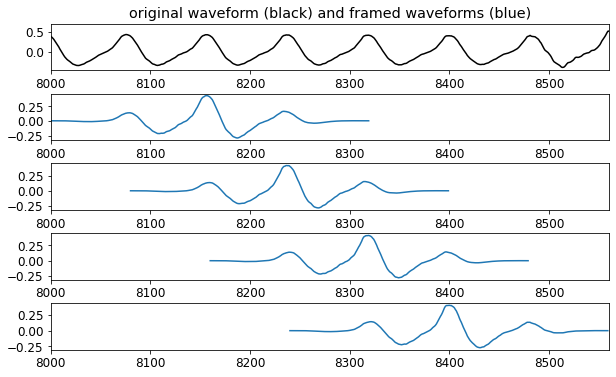

In [44]:
# Let's plot a few frames (similar)
# This is similar to that in c10_waveform_tools.
#
# function to the time index of one frame
def frame_time_idx_range(frame_idx, frame_length=frame_length, frame_shift=frame_shift):
    # return the start and end time index of the frame
    return frame_idx * frame_shift, frame_idx * frame_shift + frame_length

frame_indices = [100, 101, 102, 103]
#  the time range to plot the waveforms
plot_xlim = [frame_time_idx_range(frame_indices[0])[0], frame_time_idx_range(frame_indices[-1])[-1]]

# whole waveform
length = wave_data.shape[0]
time_idx = np.arange(length)
fig=plt.figure(); axis=fig.add_subplot(511);
axis.plot(time_idx, wave_data, color='k')
axis.set_title('original waveform (black) and framed waveforms (blue)')
axis.set_xlim(plot_xlim)

# plot a few frames
for figure_idx, frame_idx in enumerate(frame_indices):
    axis=fig.add_subplot(5, 1, figure_idx + 2);
    frame_start, frame_end = frame_time_idx_range(frame_idx, frame_length, frame_shift)
    axis.plot(np.arange(frame_start, frame_end), wave_framed[frame_idx])
    axis.set_xlim(plot_xlim)
fig.subplots_adjust(hspace=0.5)

## Auto-correlation

In this API, we use auto-correlation method (https://en.wikipedia.org/wiki/Linear_prediction). An alternative is the covariance-based method (Sec. II. B. (Makhoul 1975)).

Given a framed signal $(x_1, \cdots, x_N)$, we want to compute the auto-correlation vector $(R_0, \cdots, R_M)$, where 

$R_p = \sum_n x_n x_{n+p}$ 

The notation here is sloppy. It is recommended to check the definition in Eq.(12-15) of Makhoul, J. Linear prediction: A tutorial review. Proc. IEEE 63, 561–580 (1975).


First, let's try a naive implementation:

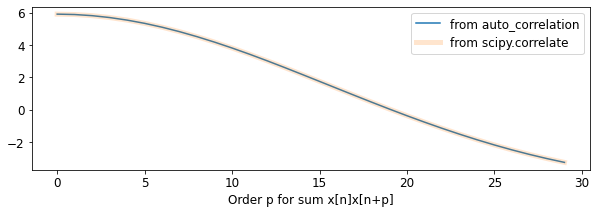

In [37]:
# A very naive implementation for one signal is like this:
def auto_correlation(frame_signal, order):
    auto_seq = np.zeros([order])
    for i in np.arange(order):
        auto_seq[i] = 0
        for index in np.arange(len(frame_signal)):
            if (index + i) < len(frame_signal):
                auto_seq[i] += frame_signal[index] * frame_signal[index + i]
            else:
                break
    return auto_seq


# Let's choose one frame as example
frame_idx = 100
order = 30
autocorr = auto_correlation(wave_framed[100], order)

fig=plt.figure(figsize=(10, 3)); axis=fig.add_subplot(111)
axis.plot(autocorr); 
axis.set_xlabel('Order p for sum x[n]x[n+p]')

# 
# scipy also provides API for this, we can check whether we compute it correctly
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.correlate.html
#
import scipy.signal
autocorr_scipy = scipy.signal.correlate(wave_framed[100], wave_framed[100], mode='same', method='fft')
# notice that autocorr_scipy returns a symmetric vector, we only need half+1
axis.plot(autocorr_scipy[autocorr_scipy.shape[0]//2:autocorr_scipy.shape[0]//2+order], linewidth=5, alpha=0.2)
axis.legend(["from auto_correlation", "from scipy.correlate"])

# Good, the two lines are consistent

Since we have multiple frames, we may compute the auto-correlation vectors for all the frames at the same time. This is not a new algorith but just a trick to use Numpy.

Suppose we have two frames, one is [1,2,3,4,5] and the other is [6,7,8,9,10]. 

To compute $R_0$ for the two frames, we can do

$\begin{align}
\begin{bmatrix} 
R_0^{(1)} \\
R_0^{(2)}
\end{bmatrix} = 
\text{sum}(\begin{bmatrix} 
1 & 2 & 3 & 4 & 5 \\
6 & 7 & 8 & 9 & 10
\end{bmatrix} \odot \begin{bmatrix} 
1 & 2 & 3 & 4 & 5 \\
6 & 7 & 8 & 9 & 10
\end{bmatrix}, \text{axis}=1)
 \end{align}$
 
 
To compute $R_1$ for the two frames, we can do

$\begin{align}
\begin{bmatrix} 
R_1^{(1)} \\
R_1^{(2)}
\end{bmatrix} = 
\text{sum}(\begin{bmatrix} 
1 & 2 & 3 & 4 \\
6 & 7 & 8 & 9 
\end{bmatrix} \odot \begin{bmatrix} 
2 & 3 & 4 & 5 \\
7 & 8 & 9 & 10
\end{bmatrix}, \text{axis}=1)
 \end{align}$


To compute $R_2$ for the two frames, we can do

$\begin{align}
\begin{bmatrix} 
R_2^{(1)} \\
R_2^{(2)}
\end{bmatrix} = 
\text{sum}(\begin{bmatrix} 
1 & 2 & 3 \\
6 & 7 & 8 
\end{bmatrix} \odot \begin{bmatrix} 
3 & 4 & 5 \\
8 & 9 & 10
\end{bmatrix}, \text{axis}=1)
 \end{align}$

...

Then we will have $[R_0^(1), R_1^(1), \cdots]$ and $[R_0^(2), R_1^(2), \cdots]$ for the two frames, respectively. 

This is implementation in `LPClite._auto_correlation()` method.


We get 550 autocorrelation vectors of order 31


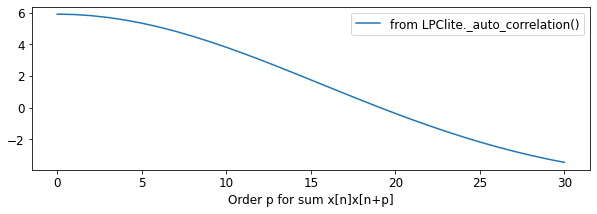

In [52]:
# Let's use the LPClite API 
autocorrs = m_lpc_api._auto_correlation(wave_framed)
# the output auto-correlation has shape (frame_num, lpc_order)

# show some numbers
frame_num, order = autocorrs.shape
print("We get {:d} autocorrelation vectors of order {:d}".format(
    frame_num, order))

# plot one frame (same as the figure above)
fig=plt.figure(figsize=(10, 3)); axis=fig.add_subplot(111)
axis.plot(autocorrs[100]); 
axis.set_xlabel('Order p for sum x[n]x[n+p]')
axis.legend(["from LPClite._auto_correlation()"])

## Levison-Durbin

### Notes on the notations

One efficient way to derive LP coefficients from auto-correlation vector is the Levison-Durbin recursion. 

Explanation can be found in Eqs(38) of (Makhoul 1975).

Given an autocorrelation vector $(R_0, R_1, \cdots, R_M)$, 

$\begin{align}
E_0 &= R_0 \\
\text{for}&\quad i \in [1, 2, \cdots, M]: \\
  & \gamma_i = - \frac{R_i + \sum_{j=1}^{i-1} a_j^{(i-1)}R_{i - j}}{E_{i-1}} \\
  & a_i^{(i)} = \gamma_i \\
  & a_j^{(i)} = a_j^{(i-1)} + \gamma_i a_{i-j}^{(i-1)} \\
  & E_i = (1 - \gamma_i^2)E_{i-1} \\
\end{align}$

Here $i$ indices the recursion cycle, and $(a_1^{(M)} , \cdots, a_M^{(M)})$ are the output LP coefficients 


Different books may have different conventions to write the Levison-Durbin recursion. 
A more detailed explanation is given in Section 5.3 of Orfanidis, S. J. Optimum Signal Processing: An Introduction. (Macmillan publishing company, 1988) (PDF is released by the author http://eceweb1.rutgers.edu/~orfanidi/osp2e/). Here, $a_0$ is introduced so that

$\begin{align}
E_0 &= R_0 \\
a_0^{0} &= 1 \\
\text{for}&\quad i \in [1, 2, \cdots, M]: \\
  & \gamma_i = \color{red}{+} \frac{\sum_{\color{red}{j=0}}^{i-1} a_j^{(i-1)}R_{i - j}}{E_{i-1}} = \color{red}{+} \frac{\sum_{\color{red}{k=1}}^{i} a_{\color{red}{i-k}}^{(i-1)}R_{\color{red}{k}}}{E_{i-1}} \\
  & a_i^{(i)} = \color{red}{-}\gamma_i \\
  & a_j^{(i)} = a_j^{(i-1)} \color{red}{-} \gamma_i a_{i-j}^{(i-1)} \\
  & E_i = (1 - \gamma_i^2)E_{i-1} \\
\end{align}$




API in this tutorial follows the convention in (Orfanidis, 1988). See more details in Sec5.3 of http://eceweb1.rutgers.edu/~orfanidi/osp2e/

### Implementation and toy example

In [129]:
# Consider a very simple example

# Consisder order=3, thus we need (R_0, R_1, R_2, R_3)
order = 3
example_autocorr = autocorrs[100][:order+1]


auto_seq = example_autocorr

# create some buffers
# a_j^i, we only need a_j^i and a_j^(i-1) for each recursion cycle, 
#  thus just 2 rows
lpc_coef = np.zeros([2, order + 1])
# E_i 
lpc_err = np.zeros([order + 1])
# \gammar 
gamma_array = np.zeros(order + 1)
    
    
# initialization    
# E_0 = R_0
lpc_err[0] = example_autocorr[0]

# Follow the convention in (Orfanidis, 1988) a_0^{0} = 1
#   as the recursion goes on, we will save the lpc coeffients in this reversed order
#      lpc_coef[0, :] = [a_M, a_M-1, ..., a_1, 1, 0, 0]
#.  this is convenient when computing \gamma
lpc_coef[0,0] = 1.0

print("Recursion process (note that the float numbers are truncated for visualization)")

for index in np.arange(1, order+1):
    print("\nLD recursion i = {:d}".format(index))
    
    # a_0^(i-1)
    lpc_coef[1,index] = 1.0
    
    # compute gamma \frac{\sum_{\color{red}{k=1}}^{i} a_{\color{red}{i-k}}^{(i-1)}R_{\color{red}{k}}}{E_{i-1}}
    # remember that we save lpc_coef[0] as [a_M, a_M-1, ..., a_1, 1]
    # thus, no need to flip it
    gamma = sum(lpc_coef[0, 0:index] * auto_seq[1:(index+1)]) / lpc_err[index-1]
    # save gamma
    gamma_array[index-1] = gamma
    
    # print information
    print("\t  E_(i-1)\n\t= {:1.3f}\n".format(lpc_err[index-1]))    
    print("\t  {:s} ".format(', '.join(["a_{:d}^(i-1)".format(index - (y+1)) for y in range(index)])))
    print("\t= [{:s}]".format(', '.join(["{:2.5f}".format(y) for y in lpc_coef[0, 0:index]])))
    print("\n\t  {:s}".format(', '.join(["R_{:d}".format(y+1) for y in range(index)])))
    print("\t= [{:s}]".format(', '.join(["{:2.5f}".format(y) for y in auto_seq[1:index+1]])))
    print("\n\t  gamma_i\n\t= {:1.5f} \n\t= np.sum(np.array( [{:s}] ) * np.array( [{:s}] )) / {:2.5f}".format(gamma, 
        ', '.join(["{:1.5f}".format(y) for _, y in enumerate(lpc_coef[0, 0:index])]), 
        ', '.join(["{:1.5f}".format(y) for _,y in enumerate(auto_seq[1:(index+1)])]),
        lpc_err[index-1]))
    
    # a_i^{(i)} = \color{red}{-}\gamma_i
    lpc_coef[1, 0] = -1.0 * gamma

    #print information
    print("\n\tWe now compute the LP coefficients")
    print("\n\t a_{:d}^i = gamma_i = {:1.3f}".format(index, lpc_coef[1, 0]))
    
    # a_j^{(i)} = a_j^{(i-1)} \color{red}{-} \gamma_i a_{i-j}^{(i-1)} 
    if index > 1:        
        for index2 in np.arange(1, index):
            lpc_coef[1, index2] = lpc_coef[0, index2-1] - gamma * lpc_coef[0, index - 1 - index2]
            
            #print information
            print("\n\t a_{:d}^i = a_{:d}^(i-1) - gamma * a_{:d}^(i-1) = {:1.3f} - {:1.3f} * {:1.3f} = {:1.3f}".format(
                index2, index2, index - index2, lpc_coef[0, index2-1], gamma, lpc_coef[0, index - 1 - index2], lpc_coef[1, index2]))
            
        #print information
        print("\n\tWe get: \t")
        print("\n\t  {:s} ".format(', '.join(["a_{:d}^(i)".format(index - (y)) for y in range(index+1)])))
        print("\t= [{:s}]".format(', '.join(["{:2.5f}".format(y) for y in lpc_coef[1, 0:index+1]])))
    
    # E_i = (1 - \gamma_i^2)E_{i-1}
    lpc_err[index] =lpc_err[index-1] * (1 - gamma * gamma)
    
    # save the lpc_coef for the next recursion cycle
    lpc_coef[0,:] = lpc_coef[1,:]

# now, we need to flip [a_M, a_M-1, ..., a_1, 1] to [1, a_1, a_2, ..., a_M]
lpc_coef_output = lpc_coef[0,::-1]
# we get the gain
gain = np.sqrt(lpc_err[-2])

Recursion process (note that the float numbers are truncated for visualization)

LD recursion i = 1
	  E_(i-1)
	= 5.910

	  a_0^(i-1) 
	= [1.00000]

	  R_1
	= [5.88580]

	  gamma_i
	= 0.99593 
	= np.sum(np.array( [1.00000] ) * np.array( [5.88580] )) / 5.90986

	We now compute the LP coefficients

	 a_1^i = gamma_i = -0.996

LD recursion i = 2
	  E_(i-1)
	= 0.048

	  a_1^(i-1), a_0^(i-1) 
	= [-0.99593, 1.00000]

	  R_1, R_2
	= [5.88580, 5.81489]

	  gamma_i
	= -0.97739 
	= np.sum(np.array( [-0.99593, 1.00000] ) * np.array( [5.88580, 5.81489] )) / 0.04802

	We now compute the LP coefficients

	 a_2^i = gamma_i = 0.977

	 a_1^i = a_1^(i-1) - gamma * a_1^(i-1) = -0.996 - -0.977 * -0.996 = -1.969

	We get: 	

	  a_2^(i), a_1^(i), a_0^(i) 
	= [0.97739, -1.96934, 1.00000]

LD recursion i = 3
	  E_(i-1)
	= 0.002

	  a_2^(i-1), a_1^(i-1), a_0^(i-1) 
	= [0.97739, -1.96934, 1.00000]

	  R_1, R_2, R_3
	= [5.88580, 5.81489, 5.69893]

	  gamma_i
	= 0.07101 
	= np.sum(np.array( [0.97739, -1.96934, 1.

### More notes

Apologize if the above process is not illustrated in a more intuitive way.
(Your suggestion is welcome)


There are two further notes:

1. We can conduct the Levison-Durbin on all the frames simultaneously. Again, this is just a trick using Numpy array, not a new algorithm;

2. We need to check whether $|\gamma|_i > 1$ for each iteration. A $|\gamma|_i > 1$ indicates an unstable synthesis filter. In practise, we can stop the recursion when $|\gamma|_i > 1$ and use the coefficients from the previous cycle $(a_1^{i-1}, a_2^{i-1}, \cdots, a_{i-1}^{i-1})$ as the final output. In other words.


These two points have been considered in `LPClite._levison_durbin()`

1. `LPClite._levison_durbin()` takes as input an array (frame_num, lpc_order+1). It work on all the frames at the same time;

2. `LPClite._levison_durbin()` handles $|\gamma|_i > 1$ in this part. Because $E_i = E_{i-1} * (1- \gamma_i^2)$, $|\gamma|_i > 1$ leads to $E_i < 0$. This is what being monitored. If $E_i < 0$, we set $gamma_i=0$ so that it will stop computation LPC cofficients for later cycles

``` python
#   step2. check validity of lpc_err
ill_idx = lpc_err[:,index-1] < 1e-07
#      also frames that should have been stopped in previous iter
ill_idx = np.bitwise_or(ill_idx, tmp_order < polyOrder)
#   step3. make invalid frame gamma=0
gamma[ill_idx] = 0
gamma[~ill_idx] = gamma[~ill_idx] / lpc_err[~ill_idx,index-1]
gamma_array[:, index-1] = gamma
#   step4. log down the ill frames
tmp_order[ill_idx] = index
```


### Example using the full speech utterance

Now let's try to use the API and analyze all the speech frames

In [133]:
# autocorrs has shape (frame_num, lpc_order + 1)
lpc_coefs, _, gammas, gains = m_lpc_api._levison_durbin(autocorrs)

# lpc_coefs has shape (frame_num, lpc_order + 1)
# gammas has shape (frame_num, lpc_order)
# gains has shape (frame_num, 1)
print("We get LPC coefficients for {:d} frames".format(lpc_coefs.shape[0]))

We get LPC coefficients for 550 frames


Let's plot the frequency response of model and spectrun of the speech frame.
We can also compare it with output of librosa.lpc

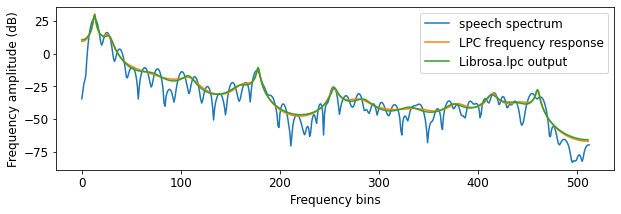

In [143]:
# choose one frame to check
frame_idx = 100
frame_waveform = wave_framed[frame_idx]
gain = gains[frame_idx][0]
lpc_coef = lpc_coefs[frame_idx]


# compute the spectrum for this frame
from scipy import signal

fft_number = 1024
plt.figure(figsize=(10,3))
fft_spec = np.fft.fft(frame_waveform, n = fft_number)[0:int(fft_number/2+1)]
plt.plot(20*np.log10(np.abs(fft_spec+1e-20)))

# compute the frequency response
_, lpc_spec = signal.freqz([gain], lpc_coef, worN = int(fft_number/2))
plt.plot(20*np.log10(np.abs(lpc_spec+1e-20)))

# if necessary, compare the results with Librosa.LPC
if True:
    import librosa
    a = librosa.lpc(frame_waveform, 29)
    _, lpc_spec = signal.freqz([gain], a, worN = int(fft_number/2))
    plt.plot(20*np.log10(np.abs(lpc_spec+1e-20)))
    
plt.xlabel('Frequency bins')
plt.ylabel('Frequency amplitude (dB)')
plt.legend(['speech spectrum', 'LPC frequency response', 'Librosa.lpc output'])

Looks acceptable!

## From reflection coefficients to LP coefficients

### Motivation

Many applications such as speech coding do not directly use LP coefficients. (See for example `Paliwal, K. K. & Atal, B. S. Efficient vector quantization of LPC parameters at 24 bits/frame. IEEE Trans. speech audio Process. 1, 3–14 (1993)`)

Alternative representations of LP coeffcients include reflection coefficients, log-area ratio, and line spectrum pairs (https://en.wikipedia.org/wiki/Line_spectral_pairs). They have nice properties, and many TTS systems use line spectrum pairs (see section 3.3.1.2 of `Zen, H., Tokuda, K. & Black, A. W. Statistical parametric speech synthesis. Speech Commun. 51, 1039–1064 (2009)`)

The reflection coefficients $\gamma$ are derived through the Levinson-Durbin recursion, and they have one-to-one mapping to the LP coefficients. A nice property is that as long as $|\gamma|<1$, the corresponding LP synthesis model is stable (i.e., all poles of $\frac{1}{1 + \sum_{p=1}^{M}a_pz^{-p}}$ stay inside the unit circle). 

If we want to predict reflection coefficients from other features, a **tanh()** activtion will make sure $|\gamma|<1$.


### rc2lpc

To convert reflection coefficients to LPC coefficients, we use the Levison-Durvin recursion.

$\begin{align}
E_0 &= R_0 \\
a_0^{0} &= 1 \\
\text{for}&\quad i \in [1, 2, \cdots, M]: \\
  & a_i^{(i)} = \color{red}{-}\gamma_i \\
  & a_j^{(i)} = a_j^{(i-1)} \color{red}{-} \gamma_i a_{i-j}^{(i-1)} \\
  & E_i = (1 - \gamma_i^2)E_{i-1} \\
\end{align}$
    
This is available in API `LPClite._rc2lpc()`

In [147]:
# Let's try one example
lpc_coefs_fromgamma = m_lpc_api._rc2lpc(gammas)

# lpc_coefs has shape (frame_num, lpc_order + 1)
# gammas has shape (frame_num, lpc_order)
# gains has shape (frame_num, 1)
print("We get LPC coefficients from reflection coef. for {:d} frames".format(lpc_coefs_fromgamma.shape[0]))

# they are identical to the lpc_coefs derived before
np.std(lpc_coefs_fromgamma - lpc_coefs)

We get LPC coefficients from reflection coef. for 550 frames


0.0

### Comparison

We mentioned the impact of quantization error. Let's check it here:

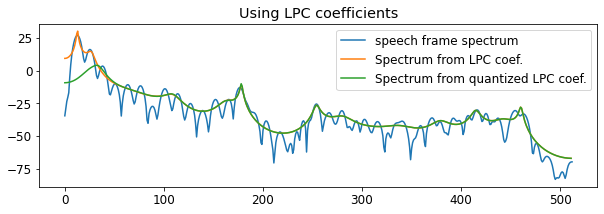

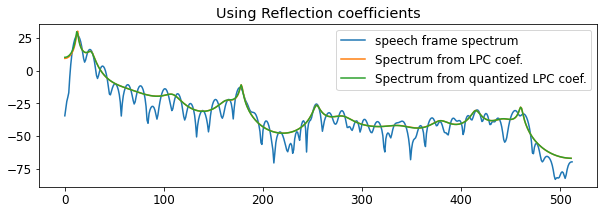

In [173]:
# select one frame
frame_idx = 100
lpc_coef = lpc_coefs[frame_idx]
gamma = gammas[frame_idx]
lpc_coef_gamma = m_lpc_api._rc2lpc(np.expand_dims(gamma, axis=0))[0]


# quantization (very simple, just truncate the float numbers, 256 = 2 ** 8 bits)
lpc_coef_quan = np.ceil(lpc_coef * 256) / 256
gamma_quan = np.ceil(gamma * 256)/256
lpc_coef_gamma_quan = m_lpc_api._rc2lpc(np.expand_dims(gamma_quan, axis=0))[0]


# for plotting figures
from scipy import signal
def log_spec(spec):
    return 20*np.log10(np.abs(spec+1e-20))
frame_waveform = wave_framed[frame_idx]
gain = gains[frame_idx][0]
fft_number = 1024
fft_spec = np.fft.fft(frame_waveform, n = fft_number)[0:int(fft_number/2+1)]

def plot_figures(lpc_coef, lpc_coef_quan, gain, fft_spec, title):
    plt.figure(figsize=(10,3))
    plt.plot(log_spec(fft_spec))

    # compute the frequency response
    _, lpc_spec = signal.freqz([gain], lpc_coef, worN = int(fft_number/2))
    plt.plot(log_spec(lpc_spec))

    # compute the frequency response
    _, lpc_spec_quan = signal.freqz([gain], lpc_coef_quan, worN = int(fft_number/2))
    plt.plot(log_spec(lpc_spec_quan))
    plt.legend(['speech frame spectrum', 'Spectrum from LPC coef.', 'Spectrum from quantized LPC coef.'])
    plt.title(title)
    return

plot_figures(lpc_coef, lpc_coef_quan, gain, fft_spec, 'Using LPC coefficients')
plot_figures(lpc_coef_gamma, lpc_coef_gamma_quan, gain, fft_spec, 'Using Reflection coefficients')

From the above figures, we see how reflection coeffcients can be useful.

In [171]:
print("LPC coef.\n", lpc_coef)
print("Quantized LPC coef.\n", lpc_coef_quan)
print("\nReflection coefficients\n", gamma)
print("Quantized Reflection coefficients\n", gamma_quan)
print("\nLPC coef. from reflection coef.\n", lpc_coef_gamma)
print("LPC coef. from quantized reflection coef.\n", lpc_coef_gamma_quan)

LPC coef.
 [ 1.         -2.25759816  1.61893504 -0.80707088  1.37205659 -1.94182127
  2.05942357 -2.52222464  3.03338199 -2.52923725  2.19015224 -3.1165879
  3.38950535 -2.52055657  2.76796376 -3.42291209  2.73144117 -2.30856245
  2.7714963  -2.5343378   1.803059   -1.78397269  1.88781544 -1.21440392
  0.7321409  -1.02763026  0.98354883 -0.54648684  0.46953537 -0.41197257
  0.14360484]
Quantized LPC coef.
 [ 1.         -2.25390625  1.62109375 -0.8046875   1.375      -1.94140625
  2.0625     -2.51953125  3.03515625 -2.52734375  2.19140625 -3.11328125
  3.390625   -2.51953125  2.76953125 -3.421875    2.734375   -2.3046875
  2.7734375  -2.53125     1.8046875  -1.78125     1.890625   -1.2109375
  0.734375   -1.02734375  0.984375   -0.54296875  0.47265625 -0.41015625
  0.14453125]

Reflection coefficients
 [ 9.95928594e-01 -9.77387668e-01  7.10054438e-02 -1.94103693e-02
 -2.63050598e-01 -1.03572519e-01  4.04988430e-01 -1.66318296e-03
  2.85567671e-01 -1.29556498e-01 -1.96712431e-01 -1.25371

### Note

It is also possible to derive reflection coefficients from LP coefficients. Please check `backward Levinson recursion` on this page http://eceweb1.rutgers.edu/~orfanidi/osp2e/


## Analysis and synthesis

### Do analysis and synthesis on one frame

Analysis and synthesis given the LPC coefficients are straightforward

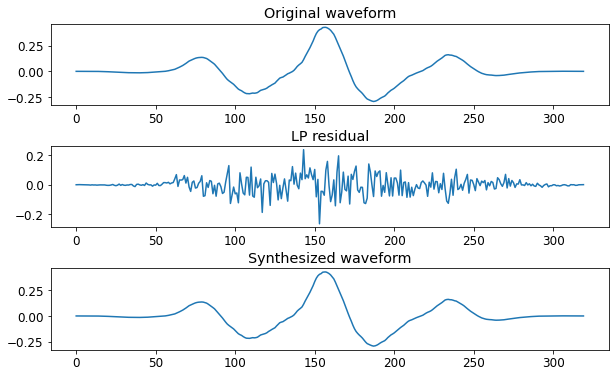

In [192]:
# take one frame as example
frame_idx = 100
lpc_coef = lpc_coefs[frame_idx]
frame_waveform = wave_framed[frame_idx]
gain = gains[frame_idx][0]
order = lpc_coef.shape[0]-1

# analysis 

# buffer to store the residual or excitation signal
frame_excit = np.zeros_like(frame_waveform)

# A simple implementation
#        e[n] = (x[n] + \sum_k=1 x[n-k] a_k) / gain
#
for i in range(frame_waveform.shape[0]):
    for k in range(1+order):
        if i-k < 0:
            break
        frame_excit[i] += frame_waveform[i-k] * lpc_coef[k]
    frame_excit[i] = frame_excit[i] / gain


# synthesis

# buffer to store the synthesized signal
frame_synthesized = np.zeros_like(frame_waveform)

# A simple implementation
#       x[n] = e[n] * gain- \sum_k=1 x[n-k] a_k
# 
for i in range(frame_waveform.shape[0]):
    frame_synthesized[i] = frame_excit[i] * gain
    for k in range(1, order+1):
        if i-k < 0:
            break
        frame_synthesized[i] -= frame_synthesized[i-k] * lpc_coef[k]
    
fig = plt.figure()
axis = fig.add_subplot(311)
axis.plot(frame_waveform)
axis.set_title("Original waveform")
axis = fig.add_subplot(312)
axis.plot(frame_excit)
axis.set_title("LP residual")
axis = fig.add_subplot(313)
axis.plot(frame_synthesized)
axis.set_title("Synthesized waveform")
fig.subplots_adjust(hspace=0.5)

### The analysis and synthesis API

This is just one example on one frame.

When doing the analysis on multiple frames, we can use Numpy.array and do it more efficiently. 

These are provided in `LPClite._lpc_analysis_core()` and `LPClite._lpc_synthesis_core()`

In [201]:
# Analysis on all the frames
# lpc_coefs,   (frame_num, order + 1)
# wave_framed, (frame_num, frame_length)
# gains,       (frame_num, 1)
# frame_excit, (frame_num, frame_length)
frame_excit = m_lpc_api._lpc_analysis_core(lpc_coefs, wave_framed, gains)

# Synthesis on all the frames
frame_wave_synthesized = m_lpc_api._lpc_synthesis_core(lpc_coefs, frame_excit, gains)

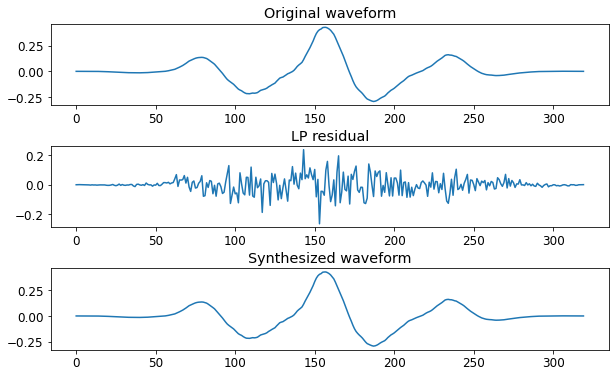

In [202]:
# Plot some figures

# take one frame as example
frame_idx = 100
fig = plt.figure()
axis = fig.add_subplot(311)
axis.plot(wave_framed[frame_idx])
axis.set_title("Original waveform")
axis = fig.add_subplot(312)
axis.plot(frame_excit[frame_idx])
axis.set_title("LP residual")
axis = fig.add_subplot(313)
axis.plot(frame_wave_synthesized[frame_idx])
axis.set_title("Synthesized waveform")
fig.subplots_adjust(hspace=0.5)

## Overlap-add

After doing analysis and synthesis on each frame, we can do overlap-add to "concatenate" the waveform in frames into a single waveform.

This topic is explained in `c10_waveform_tools`. The method is also included as `LPClite._overlapadd()`

'Original waveform'

'LP analysis and synthesized'

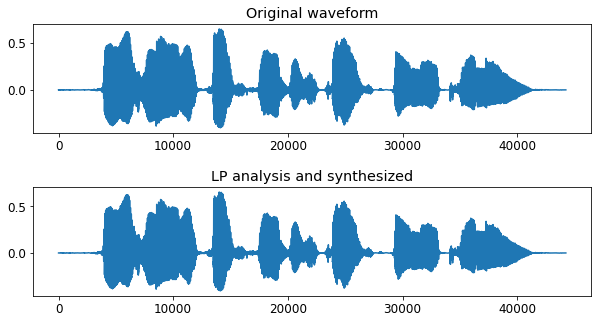

In [211]:
# The outptu will be (length, 1)
waveform_reconstructed = m_lpc_api._overlapadd(frame_wave_synthesized)

fig = plt.figure(figsize=(10, 5))
axis = fig.add_subplot(211)
axis.plot(wave_data)
axis.set_title('Original waveform')
axis = fig.add_subplot(212)
axis.plot(waveform_reconstructed)
axis.set_title('LP analysis and synthesized')
fig.subplots_adjust(hspace=0.5)

IPython.display.display('Original waveform')
IPython.display.display(IPython.display.Audio(wave_data, rate=sampling_rate, normalize=False))
IPython.display.display('LP analysis and synthesized')
IPython.display.display(IPython.display.Audio(waveform_reconstructed[:, 0], rate=sampling_rate, normalize=False))

We can also overlap-add the excitation waveforms in each frame

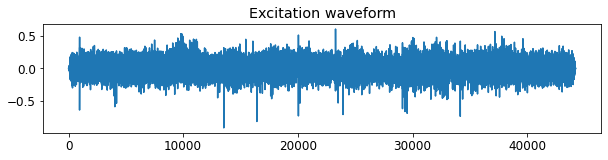

In [216]:
# The outptu will be (length, 1)
waveform_excitation = m_lpc_api._overlapadd(frame_excit)
waveform_excitation = waveform_excitation[:, 0]

fig = plt.figure(figsize=(10, 2))
axis = fig.add_subplot(111)
axis.plot(waveform_excitation)
axis.set_title('Excitation waveform')

# If you want to play the audio, please decrease the volume
#IPython.display.display('Excitation waveform')
#IPython.display.display(IPython.display.Audio(waveform_excitation, rate=sampling_rate, normalize=False))

# If you want to check the spectrogram
if False:
    excit_spectrogram = tool_lib.spec_amplitude(waveform_excitation, fft_bins=4096, frame_shift=40, frame_length=240)
    fig=plt.figure(); axis=fig.add_subplot(211);
    plot_lib.plot_spectrogram(excit_spectrogram, fig, axis, "", "frequency (kHz)", sampling_rate = sampling_rate, title='Excitation signal')

Note that the above excitation waveform is from $\frac{G}{1 + \sum_{p=1}^{M}a_pz^{-p}}$, with $G$ into consideration.

You may try to do analysis and synthesis without the gain $G$.

## Wrapper functions

The LPClite provides high level APIs to do analysis and synthesis

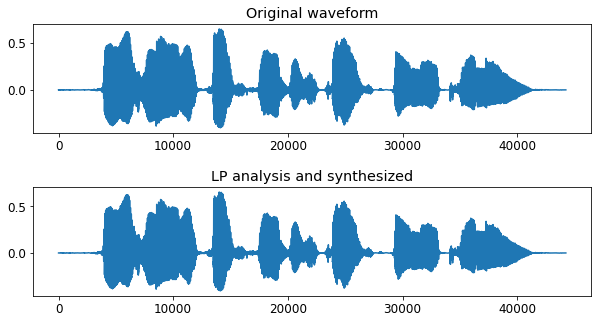

In [223]:
# claim an LPC object
frame_shift = 80
frame_length = 320
order = 30

m_lpc_api = LPClite(frame_length, frame_shift, order, flag_emph=False)

# load waveform
wavfile_path = './data_models/acoustic_features/hn_nsf/slt_arctic_b0474.wav'
sampling_rate, wave_data = tool_lib.waveReadAsFloat(wavfile_path)


# do analysis
# The API accepts waveform in shape (length, 1)
wave_data = np.expand_dims(wave_data, axis=1)
lpc_coefs, _, gammas, gains, frame_excit, _ = m_lpc_api.analysis(wave_data)

# do synthesis
# The API returns waveform in shape (length, 1)
waveform_reconstructed = m_lpc_api.synthesis(lpc_coefs, frame_excit, gains)
waveform_reconstructed = waveform_reconstructed[:, 0]


# plot figures
fig = plt.figure(figsize=(10, 5))
axis = fig.add_subplot(211)
axis.plot(wave_data)
axis.set_title('Original waveform')
axis = fig.add_subplot(212)
axis.plot(waveform_reconstructed)
axis.set_title('LP analysis and synthesized')
fig.subplots_adjust(hspace=0.5)

<a id="finalnote"></a>
## Final note on its usage for Pytorch project
The API above are based on Numpy. I personally use them to get the numpy array before they are converted into torch.tensor.

A good place to plug it in is the data transformation functions in `core_scripts/data_io/default_data_io.py f_post_data_process()`

In this way, LPC analysis can be conducted after getting the wavefrom from disk

```c
waveform data on disk ----> DataSet.__getitem__()  -----> Collate  ---->  Pytorch model
                                numpy.tensor           torch.tensor
                                LPC analysis
```

Examples to be uploaded


That's all